In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.io as sio

In [2]:
data = sio.loadmat('mnist.mat')
X = data['trainX'].astype(float)/255
y = data['trainY'][0,:]
idx = np.less(y,5)
X = X[idx,:]
y = y[idx]
X = X[:1000,:]
y = y[:1000]
m,n = X.shape
print(X.shape,y.shape)


(1000, 784) (1000,)


In [3]:
def get_distance(X,z,D1=None): 
    if D1 is None:
        D1 = np.sum(np.power(X,2),1)

    # return a vector of length m with distances from z to all elements in X
    # use convention d(x,y) = ||x-y||_2^2
    
    
    if len(z.shape) ==1:
        D2 = np.dot(X,z)
        D3 = np.dot(z,z)
        return D1-2*D2+D3
    else:
        D2 = np.dot(X,z.T)
        D3 = np.sum(np.power(z,2.),1)
        return np.outer(D1,np.ones(z.shape[0])) - 2*D2 + np.outer(np.ones(X.shape[0]),D3)

# Don't change this! Return what you see printed out.
print(np.sum(get_distance(X,np.array(range(n)))))

160239119987.1912


0.712910994356051


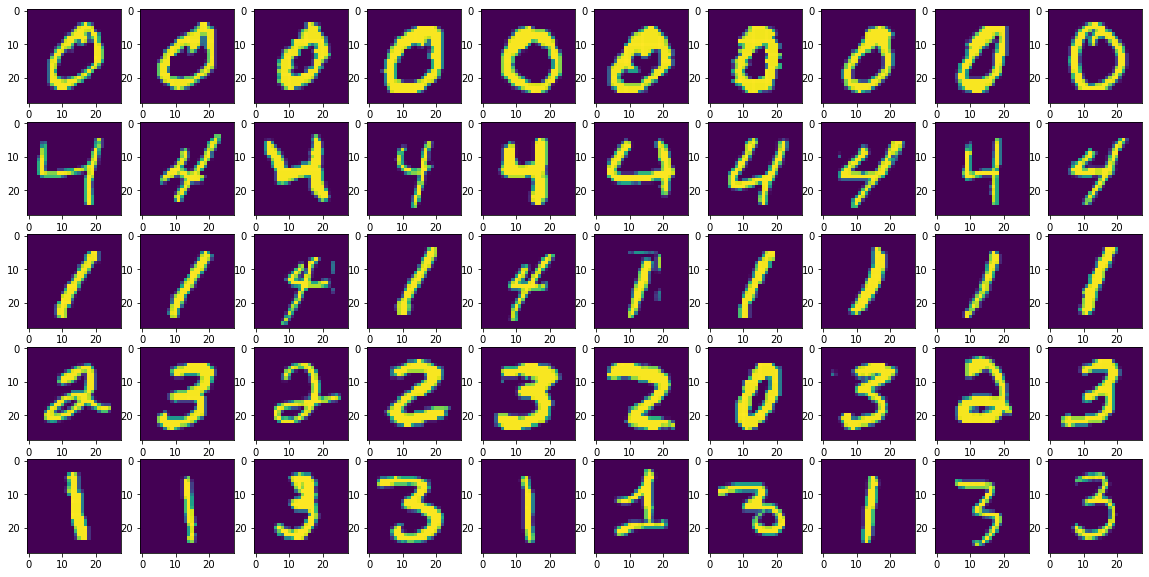

In [9]:




def kmeans(X,K,verbose = False):
    D1 = np.sum(np.power(X,2),1)
    m = X.shape[0]
    mu = X[:K,:]+0
    dist_to_centers = np.zeros((m,K))
    for iter in range(10):
        for k in range(K):
            dist_to_centers[:,k] = get_distance(X,mu[k,:],D1)
        if verbose: print(np.sum(np.min(dist_to_centers,axis=1)))

        class_membership = np.argmin(dist_to_centers,axis=1)

        for k in range(K):
            mu[k,:] = np.mean(X[np.equal(class_membership,k),:],axis=0)
    return  class_membership


def plot_class_membership(class_membership):
    plt.figure(figsize=(20,10)) 
    
    for k in range(K):
        S = np.where(np.equal(class_membership,k))[0]
        for ii in range(min(10,len(S))):
            i = S[ii]
            plt.subplot(K,10,10*k+ii+1)
            plt.imshow(np.reshape(X[i,:],(28,28)))
        
    
def purity(S):
    sizes = np.zeros(K)
    for k in range(K):
        sizes[k] = np.sum(np.equal(y[S],k))
    
    return np.max(sizes)/len(S)
def overall_purity(class_membership) :
    purity_score = 0.
    for k in range(K):
        purity_score += purity(np.where(np.equal(class_membership,k))[0])
    return purity_score / K
K = 5
class_membership = kmeans(X,K)

print(overall_purity(class_membership))
plot_class_membership(class_membership)
plt.savefig('mnist_clustering_soln/vanilla.png')



X_demean = X - np.outer(np.ones(X.shape[0]),np.mean(X,axis=0))

In [10]:
# PCA
u,s,vt = np.linalg.svd(X, full_matrices = False)

for dim in [10,100,500]:
    X_pca = np.dot(u[:,:dim]*s[:dim],vt[:dim,:])
    class_membership = kmeans(X_pca,K)
    
    print(overall_purity(class_membership))
    
    
    



0.7130737784713073
0.7129877756828321
0.712910994356051


In [12]:
# JL

for dim in [10,100,500]:
    A = np.random.randn(n,dim)
    X_jl = np.dot(X,A)
    class_membership = kmeans(X_jl,K)
    
    print(overall_purity(class_membership))
    



0.42982720065826435
0.7473063015984943
0.6999565992539338


In [13]:
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.csgraph import shortest_path
num_nearest = 4

I = []
J = []
D1 = np.sum(np.power(X,2),1)
offset = 0
blksize = 1000
while offset < m:
    if offset % 10000 == 0:
        print(offset,m)
    blksize = min(m-offset,blksize)
    idx = range(offset, offset + blksize) 
    d = get_distance(X,X[idx,:],D1)
    for i in range(len(idx)):
        nearest = np.argpartition(d[:,i],num_nearest)[:num_nearest]
        I.extend([offset + i for j in range(num_nearest)])
        J.extend(nearest)
    offset += blksize

adj = coo_matrix((np.ones(len(I)),(I,J)),shape=(m,m))
adj = csr_matrix(adj)
adj = (adj + adj.T)/2.



dist_matrix = shortest_path(csgraph=adj, directed=False)

dist_matrix = dist_matrix - np.outer(np.ones(m),np.mean(dist_matrix,axis=0))
dist_matrix = dist_matrix - np.outer(np.mean(dist_matrix,axis=1),np.ones(m))
dist_matrix= (dist_matrix+ dist_matrix.T)/2. + np.eye(m)
d,X_isomap = np.linalg.eig(dist_matrix)
X_isomap = X_isomap * d




0 1000


In [14]:

idx = np.flip(np.argsort(d)) 
for dim in [10,100,500]:
    
    X_isomap_red = X_isomap[:,idx[:dim]]
    class_membership = kmeans(X_isomap_red,K)
    
    print(overall_purity(class_membership))
    


0.27721417407299037
0.27784103867203724
0.2760008107878752


In [17]:
#LLE
from scipy.sparse.linalg import eigs
stepsize = 0.001
adj = coo_matrix(adj)
W = coo_matrix(adj + 0.)
 
for iter in range(10):
    H = W*X-X
    grad = np.dot(H,X.T)
    grad = coo_matrix((grad[W.row,W.col], (W.row, W.col)),shape=W.shape)
    W = coo_matrix(W - grad * stepsize)
    Wsum = W*np.ones(W.shape[0])
    W.data = W.data / Wsum[W.row]
   
    

d,v = eigs(W,501)
d = np.real(d)
v = np.real(v)

X_LLE = v*d

for dim in [10,100,500]:
    X_LLE_red = X_LLE[:,:dim]
    class_membership = kmeans(X_LLE_red,K)
    
    print(overall_purity(class_membership))


0.8242001842396348
0.5304436447241965
0.651683496589892


In [19]:
#spectral clustering
from scipy.sparse import diags 
from scipy.sparse.linalg import eigs

L = diags(adj*np.ones(m) )- adj
L = (L+L.T)/2.
d,v = eigs(L, k=500,which='LR')
d = np.real(d)
v = np.real(v)
X_specemb = v*np.sqrt(d)


for dim in [10,100,500]:
    X_specemb_red = X_specemb[:,:dim]
    class_membership = kmeans(X_specemb_red,K)
    
    print(overall_purity(class_membership))
    


0.6303471520053926
0.7180702310939748
0.7435045317220543


0.7578501280368608
0.94218800038834
0.849430937361255


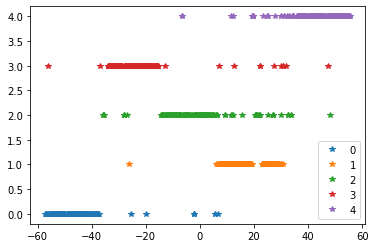

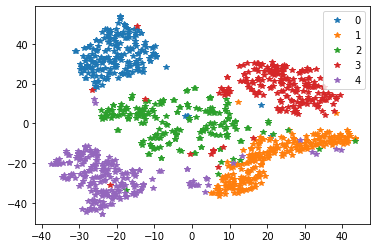

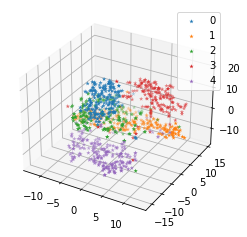

In [21]:
#tsne
from sklearn.manifold import TSNE
m,n = X.shape



for dim in [1,2,3]:
    tsne = TSNE(n_components=dim)
    X_tsne = tsne.fit_transform(X)
    if dim == 1:
        plt.figure()
        for k in range(K):
            plt.plot(X_tsne[np.equal(y,k)],y[np.equal(y,k)],marker='*',linewidth=0,label=k)
        plt.legend()
        plt.savefig('mnist_clustering_soln/tsnevis_1d.png')
    if dim == 2:
        plt.figure()
        for k in range(K):
            plt.plot(X_tsne[np.equal(y,k),0],X_tsne[np.equal(y,k),1],marker='*',linewidth=0,label=k)
        plt.legend()
        plt.savefig('mnist_clustering_soln/tsnevis_2d.png')
    if dim == 3:
        
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for k in range(K):
            ax.scatter(X_tsne[np.equal(y,k),0],X_tsne[np.equal(y,k),1],X_tsne[np.equal(y,k),2],marker='*',linewidth=0,label=k)
        plt.legend()
        plt.savefig('mnist_clustering_soln/tsnevis_3d.png')
    
    
    class_membership = kmeans(X_tsne,K)
    
    print(overall_purity(class_membership))
    
    
    